In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from astropy.table import Table
import matplotlib.gridspec as gridspec
from iminuit import Minuit
import fkplotlib
import cmocean

# Beammap

In [ ]:
maps = readsav("Data/kid_maps_20180122s309_2.save", python_dict=True)
s = slice(70, 150)
vmax = np.max(maps["map_list_azel"])

fig, axs = plt.subplots(12, 12, figsize=(9.5, 9.5))
axs = axs.flatten()
for i in range(maps["map_list_azel"].shape[-1]):
    ax = axs[i]
    ax.imshow(maps["map_list_azel"][s, s, i], cmap="bone_r", interpolation="none", vmin=0, vmax=vmax)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
fig.subplots_adjust(hspace=0.05, wspace=0.05, left=0.01, right=0.99, bottom=0.01, top=0.99)

# Pointing

In [2]:
m = readsav("Data/20180115s101/results.save", python_dict=True)

<IPython.core.display.Javascript object>


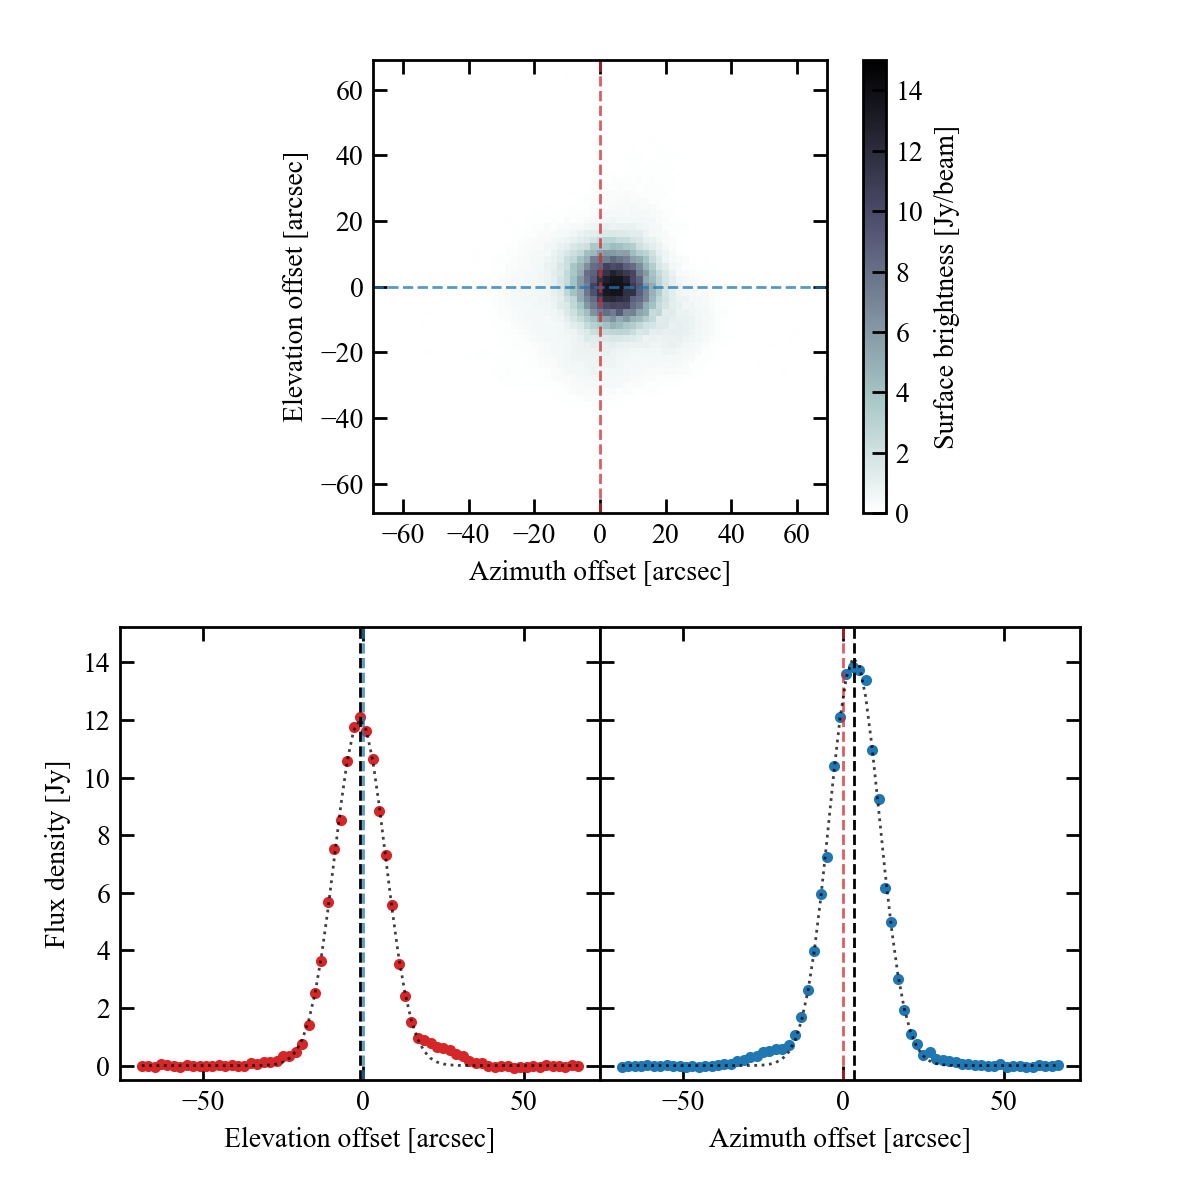

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.407                      │        Ncalls = 55 (55 total)        │
│ EDM = 3.54e-06 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.969                      │        Ncalls = 69 (69 total)        │
│ EDM = 9.17e-07 (Goal: 0.0002)    │               up = 1.0               │
├───────────

In [3]:
plt.close("all")
s = slice(66, 135)
d = m["grid1"]["MAP_I_2MM"][0][s, s]
reso = m["grid1"]["CDELT"][0][1] * 3600. # arcsec
d2 = d.shape[0] / 2
x = np.arange(-d2, d2) * reso

fig = plt.figure(figsize=(6, 6))
axs = [fig.add_subplot(i) for i in [211, 223, 224]]

im = axs[0].imshow(
    d, interpolation="none", cmap="bone_r", vmin=0, vmax=15, 
    extent=(-d2 * reso, d2 * reso, -d2 * reso, d2 * reso)
)
axs[0].axhline(0, 0, 1, color="tab:blue", ls="--", alpha=0.75)
axs[0].axvline(0, 0, 1, color="tab:red", ls="--", alpha=0.75)
axs[0].set_xlabel("Azimuth offset [arcsec]")
axs[0].set_ylabel("Elevation offset [arcsec]")
axs[0].set_xticks(np.arange(-60, 61, 20))
axs[0].set_yticks(np.arange(-60, 61, 20))
fkplotlib.ax_bothticks(axs[0])
cb = fig.colorbar(im, cax=fig.add_subplot(276, aspect=20))
cb.set_label("Surface brightness [Jy/beam]")

az = d[:, int(d2)]
el = d[int(d2), :]
for prof, ax, color in zip([az, el], axs[1:], ["tab:red", "tab:blue"]):
    ax.plot(x, prof, ".", color=color)
axs[1].axvline(0, 0, 1, color="tab:blue", ls="--", alpha=0.75)
axs[2].axvline(0, 0, 1, color="tab:red", ls="--", alpha=0.75)
axs[1].set_xlabel("Elevation offset [arcsec]")
axs[2].set_xlabel("Azimuth offset [arcsec]")
for ax in axs[1:]:
    ax.set_ylim(-0.5, 1.1 * np.max([az.max(), el.max()]))
    fkplotlib.ax_bothticks(ax)
axs[2].set_yticklabels([])
axs[1].set_ylabel("Flux density [Jy]")
fig.subplots_adjust(wspace=0, hspace=0.25, left=0.1, right=0.9, top=0.95, bottom=0.1)

def gauss(x, a, mu, fwhm):
    sig = fwhm * 0.4247
    return a * np.exp(-0.5 * ((x - mu) / sig) ** 2)
def chi2_az(a, mu, fwhm):
    model = gauss(x, a, mu, fwhm)
    return np.sum((az - model) ** 2)
def chi2_el(a, mu, fwhm):
    model = gauss(x, a, mu, fwhm)
    return np.sum((el - model) ** 2)

for chi2, ax, in zip([chi2_az, chi2_el], axs[1:]):
    mig = Minuit(chi2, a=10.0, mu=0.0, fwhm=18.0, errordef=1, print_level=2).migrad()
    res = [mig.params[i].value for i in range(3)]
    ax.plot(x, gauss(x, *res), color="k", ls=":", alpha=0.75)
    ax.axvline(res[1], 0, 1, color="k", ls="--")

fig.savefig("pointing.pdf")

In [ ]:
print(m.keys())
print([c for c in Table(m['grid1']).colnames if "toi" in c])

In [ ]:
cmocean.cm.ice